# Beginner's Tutorial to Titanic Survival Challenge using scikit-learn


## Preparación del Notebook

### Importación de Librerías

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
import opendatasets as od

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
#from sklearn.metrics import accuracy_scor

### Descarga de Datasets desde Kaggle

In [2]:
od.download("https://www.kaggle.com/c/titanic/data")
{"username":"dgrone","key":"8e16739c70ce24ea1e6d9a45b61e9796"}

Skipping, found downloaded files in ".\titanic" (use force=True to force download)


{'username': 'dgrone', 'key': '8e16739c70ce24ea1e6d9a45b61e9796'}

### Carga de Datasets

In [3]:
#train_folder = "c:/Users/pablo/OneDrive/Documentos/GitHub/MDS-Notebooks/03-MLA/titanic/train.csv"
train_folder = "titanic/train.csv"
train_df = pd.read_csv(train_folder)

In [4]:
#test_folder = "c:/Users/pablo/OneDrive/Documentos/GitHub/MDS-Notebooks/03-MLA/titanic/test.csv"
test_folder = "titanic/test.csv"
test_df = pd.read_csv(test_folder)

## 1.- Limpieza de Datos

### 1.1.- Visualización del Dataframe de Datos de Entrenamiento

In [6]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Lista de Características

In [7]:
pd.DataFrame(train_df.columns.values).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
0,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


##### Características Categóricas

In [8]:
train_categorical = train_df.select_dtypes(include=['object','category'])
pd.DataFrame(train_categorical.columns.values).transpose()

,0,1,2,3,4
0,Name,Sex,Ticket,Cabin,Embarked


##### Características Numéricas

In [9]:
train_numerical = train_df.select_dtypes(include=['number'])
pd.DataFrame(train_numerical.columns.values).transpose()

,0,1,2,3,4,5,6
0,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare


### 1.2.- Exploración de Datos

##### Exploración Información de Datos

In [62]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    891 non-null    int64
 1   Pclass      891 non-null    int64
 2   Sex         891 non-null    int32
 3   Age         891 non-null    int32
 4   SibSp       891 non-null    int64
 5   Fare        891 non-null    int32
 6   Embarked    891 non-null    int32
 7   Title       891 non-null    int64
 8   FamilySize  891 non-null    int64
 9   IsAlone     891 non-null    int64
 10  Age*Class   891 non-null    int64
dtypes: int32(4), int64(7)
memory usage: 62.8 KB


##### Análisis Estadísticos

In [12]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Analyze by pivoting features
To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.
* **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
* **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
* **SibSp and Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

In [14]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [15]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [16]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [17]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Analyze by visualizing data
Now we can continue confirming some of our assumptions using visualizations for analyzing the data.
### Correlating numerical features
Let us start by understanding correlations between numerical features and our solution goal (Survived).
A histogram chart is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)
Note that x-axis in historgram visualizations represents the count of samples or passengers.

**Observations:**
* Infants (Age <=4) had high survival rate.
* Oldest passengers (Age = 80) survived.
* Large number of 15-25 year olds did not survive.
* Most passengers are in 15-35 age range.

**Decisions:**

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.
* We should consider Age (our assumption classifying #2) in our model training.
* Complete the Age feature for null values (completing #1).
* We should band age groups (creating #3).

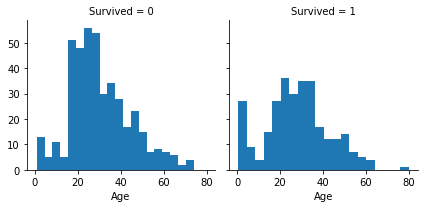

In [18]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Correlating numerical and ordinal features
We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.
**Observations:**
* Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
* Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
* Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
* Pclass varies in terms of Age distribution of passengers.

**Decisions:**
* Consider Pclass for model training.

C:\Users\pablo\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


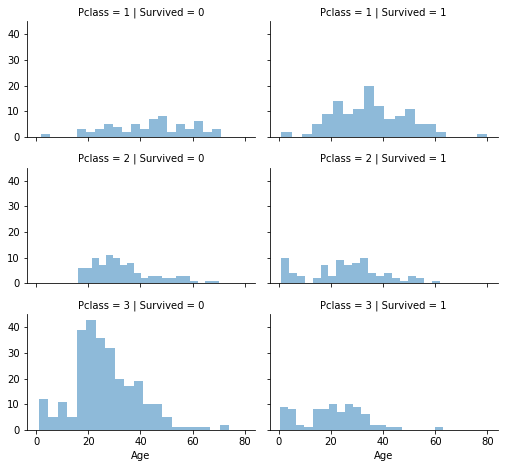

In [19]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Correlating categorical features
Now we can correlate categorical features with our solution goal.

**Observations:**
* Female passengers had much better survival rate than males. Confirms classifying (#1).
* Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
* Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
* Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

**Decisions:**
* Add Sex feature to model training.
* Complete and add Embarked feature to model training.

C:\Users\pablo\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\pablo\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\pablo\anaconda3\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


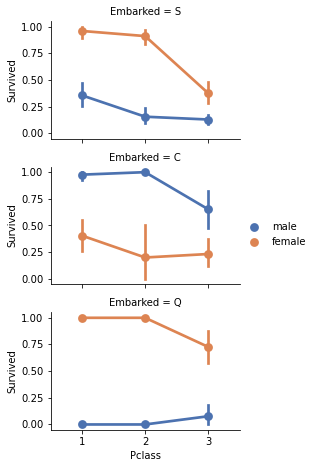

In [20]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Correlating categorical and numerical features
We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric).

**Observations:**
* Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
* Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

**Decisions:**
* Consider banding Fare feature.

C:\Users\pablo\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\pablo\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


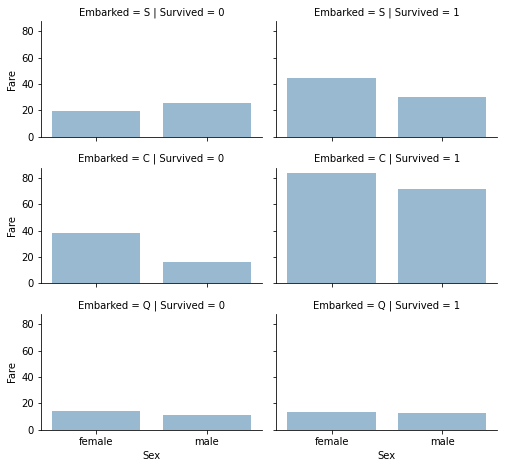

In [21]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

### Wrangle data
We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

### Correcting by dropping features
This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.
Based on our assumptions and decisions we want to drop the Cabin (correcting #2) and Ticket (correcting #1) features.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [22]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

### Creating new feature extracting from existing
We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features.

In the following code we extract Title feature using regular expressions. The RegEx pattern (\w+\.) matches the first word which ends with a dot character within Name feature. The expand=False flag returns a DataFrame.

**Observations:**

When we plot Title, Age, and Survived, we note the following observations.
* Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.
* Survival among Title Age bands varies slightly.
* Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

**Decision:**
* We decide to retain the new Title feature for model training.

In [23]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We can replace many titles with a more common name or classify them as Rare.

In [24]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Jonkheer', 'Dona'], 'Lady')
    dataset['Title'] = dataset['Title'].replace(['Capt', 'Don', 'Major', 'Sir'], 'Sir')
    
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Col,0.500000
1,Dr,0.428571
2,Lady,0.666667
3,Master,0.575000
4,Miss,0.702703
5,Mr,0.156673
6,Mrs,0.793651
7,Rev,0.000000
8,Sir,0.400000


We can convert the categorical titles to ordinal.

In [25]:
title_mapping = {"Col": 1, "Dr": 2, "Lady": 3, "Master": 4, "Miss": 5, "Mr": 6, "Mrs": 7, "Rev": 8, "Sir": 9}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,6
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,5
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,7
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,6


Now we can safely drop the Name feature from training and testing datasets. We also do not need the `PassengerId` feature in the training dataset.

In [26]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### Converting a categorical feature
Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

Let us start by converting Sex feature to a new feature called Gender where female=1 and male=0.

In [27]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,6
1,1,1,1,38.0,1,0,71.2833,C,7
2,1,3,1,26.0,0,0,7.9250,S,5
3,1,1,1,35.0,1,0,53.1000,S,7
4,0,3,0,35.0,0,0,8.0500,S,6


### Completing a numerical continuous feature
Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

We can consider three methods to complete a numerical continuous feature.

* A simple way is to generate random numbers between mean and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation).
* More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using [median](https://en.wikipedia.org/wiki/Median) values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...
* Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will prefer method 2.

C:\Users\pablo\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


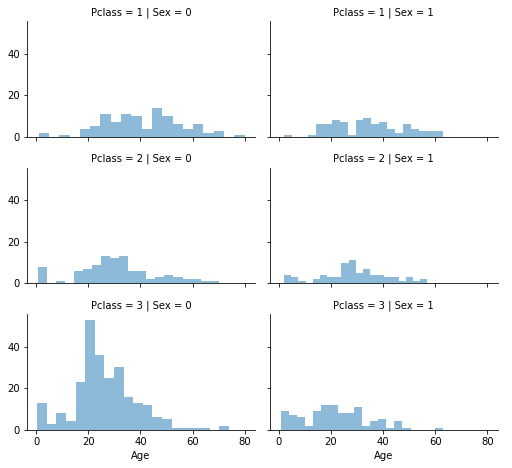

In [28]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass x Gender combinations.

In [29]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

Now we iterate over Sex (0 or 1) and Pclass (1, 2, 3) to calculate guessed values of Age for the six combinations.

In [30]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,6
1,1,1,1,38,1,0,71.2833,C,7
2,1,3,1,26,0,0,7.9250,S,5
3,1,1,1,35,1,0,53.1000,S,7
4,0,3,0,35,0,0,8.0500,S,6


Let us create Age bands and determine correlations with Survived.

In [31]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Let us replace Age with ordinals based on these bands.

In [32]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,6,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,7,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,5,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,7,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,6,"(32.0, 48.0]"


We can not remove the AgeBand feature.

In [33]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,6
1,1,1,1,2,1,0,71.2833,C,7
2,1,3,1,1,0,0,7.9250,S,5
3,1,1,1,2,1,0,53.1000,S,7
4,0,3,0,2,0,0,8.0500,S,6


### Create new feature combining existing features
We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [34]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


We can create another feature called IsAlone.

In [35]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Let us drop Parch, SibSp, and FamilySize features in favor of IsAlone.

In [36]:
train_df = train_df.drop(['Parch',], axis=1)
test_df = test_df.drop(['Parch'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,0,1,1,7.2500,S,6,2,0
1,1,1,1,2,1,71.2833,C,7,2,0
2,1,3,1,1,0,7.9250,S,5,1,1
3,1,1,1,2,1,53.1000,S,7,2,0
4,0,3,0,2,0,8.0500,S,6,1,1


We can also create an artificial feature combining Pclass and Age.

In [37]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature
Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [38]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [39]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Converting categorical feature to numeric
We can now convert the EmbarkedFill feature by creating a new numeric Port feature.

In [40]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
0,0,3,0,1,1,7.2500,0,6,2,0,3
1,1,1,1,2,1,71.2833,1,7,2,0,2
2,1,3,1,1,0,7.9250,0,5,1,1,3
3,1,1,1,2,1,53.1000,0,7,2,0,2
4,0,3,0,2,0,8.0500,0,6,1,1,6


## Quick completing and converting a numeric feature
We can now complete the Fare feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

Note that we are not creating an intermediate new feature or doing any further analysis for correlation to guess missing feature as we are replacing only a single value. The completion goal achieves desired requirement for model algorithm to operate on non-null values.

We may also want round off the fare to two decimals as it represents currency.

In [41]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
0,892,3,0,2,0,7.8292,2,6,1,1,6
1,893,3,1,2,1,7.0000,0,7,2,0,6
2,894,2,0,3,0,9.6875,2,6,1,1,6
3,895,3,0,1,0,8.6625,0,6,1,1,3
4,896,3,1,1,1,12.2875,0,7,3,0,3


We can not create FareBand.

In [42]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Convert the Fare feature to ordinal values based on the FareBand.

In [43]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
0,0,3,0,1,1,0,0,6,2,0,3
1,1,1,1,2,1,3,1,7,2,0,2
2,1,3,1,1,0,1,0,5,1,1,3
3,1,1,1,2,1,3,0,7,2,0,2
4,0,3,0,2,0,1,0,6,1,1,6
5,0,3,0,1,0,1,2,6,1,1,3
6,0,1,0,3,0,3,0,6,1,1,3
7,0,3,0,0,3,2,0,4,5,0,0
8,1,3,1,1,0,1,0,7,3,0,3
9,1,2,1,0,1,2,1,7,2,0,0


In [44]:
# Test dataset
test_df.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
0,892,3,0,2,0,0,2,6,1,1,6
1,893,3,1,2,1,0,0,7,2,0,6
2,894,2,0,3,0,1,2,6,1,1,6
3,895,3,0,1,0,1,0,6,1,1,3
4,896,3,1,1,1,1,0,7,3,0,3
5,897,3,0,0,0,1,0,6,1,1,0
6,898,3,1,1,0,0,2,5,1,1,3
7,899,2,0,1,1,2,0,6,3,0,2
8,900,3,1,1,0,0,1,7,1,1,3
9,901,3,0,1,2,2,0,6,3,0,3


## Model, predict and solve
Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. 
With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:
* Logistic Regression
* KNN or k-Nearest Neighbors
* Support Vector Machines
* Naive Bayes classifier
* Decision Tree
* Random Forrest
* Perceptron
* Artificial neural network
* RVM or Relevance Vector Machine

In [45]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

X_train.head(10)

,Pclass,Sex,Age,SibSp,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
0,3,0,1,1,0,0,6,2,0,3
1,1,1,2,1,3,1,7,2,0,2
2,3,1,1,0,1,0,5,1,1,3
3,1,1,2,1,3,0,7,2,0,2
4,3,0,2,0,1,0,6,1,1,6
5,3,0,1,0,1,2,6,1,1,3
6,1,0,3,0,3,0,6,1,1,3
7,3,0,0,3,2,0,4,5,0,0
8,3,1,1,0,1,0,7,3,0,3
9,2,1,0,1,2,1,7,2,0,0


In [46]:
Y_train.head(10)

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

In [47]:
X_test.head(10)

,Pclass,Sex,Age,SibSp,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
0,3,0,2,0,0,2,6,1,1,6
1,3,1,2,1,0,0,7,2,0,6
2,2,0,3,0,1,2,6,1,1,6
3,3,0,1,0,1,0,6,1,1,3
4,3,1,1,1,1,0,7,3,0,3
5,3,0,0,0,1,0,6,1,1,0
6,3,1,1,0,0,2,5,1,1,3
7,2,0,1,1,2,0,6,3,0,2
8,3,1,1,0,0,1,7,1,1,3
9,3,0,1,2,2,0,6,3,0,3


Logistic Regression is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. 
Reference [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

Note the confidence score generated by the model based on our training dataset.

# AQUI EMPIEZA EL MACHINE LEARNING

The perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. 
Reference [Wikipedia](https://en.wikipedia.org/wiki/Perceptron).

In [53]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.24